Load libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import pandas as pd

Load data

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

Show Example

In [3]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Prepare data

In [4]:
# Drop missing values
dataset = dataset.dropna()

# Convert Origin to Numeric
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset['Europe'] = dataset['Europe'].apply(int)
dataset['Japan'] = dataset['Japan'].apply(int)
dataset['USA'] = dataset['USA'].apply(int)
dataset.tail()

# Split dataset into inputs and labels
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

# Normalize inputs
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Convert numpy arrays to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Create dataset and dataloader
dataset = torch.utils.data.TensorDataset(X, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Neural Network #1

In [5]:
class RegressionModel1(torch.nn.Module):
    def __init__(self,input_size):
        super(RegressionModel1, self).__init__()
        self.layer1=torch.nn.Linear(input_size, 1)

    def forward(self,x):
        x=self.layer1(x)
        return x

nnet=RegressionModel1(9)

In [6]:
from torchinfo import summary

batch_size= 32

summary(nnet, input_size=(batch_size,9),device='cpu')

/Users/grad/opt/anaconda3/envs/pt2/lib/python3.8/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/grad/opt/anaconda3/envs/pt2/lib/python3.8/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
RegressionModel1                         [32, 1]                   --
├─Linear: 1-1                            [32, 1]                   10
Total params: 10
Trainable params: 10
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [7]:
import torch.optim as optim

criterion = torch.nn.MSELoss()
optimizer= torch.optim.SGD(nnet.parameters(), lr=0.01)

In [8]:
# Define an empty list to store the loss values
loss_list1 = []

for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get inputs
        inputs, labels = data
        
        #zero parameter gradients
        optimizer.zero_grad()

        #forward, backward, optimize
        outputs = nnet(inputs)
        loss=criterion(outputs,labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        #print
        running_loss += loss.item()
        if i % 12 == 11:
            print(f'[{epoch + 1}, {i+1:5d}] loss: {running_loss / 12:.3f}')
            running_loss=0.0
            
    loss_list1.append(running_loss / len(trainloader))
print('Finished Training')


[1,    12] loss: 466.270
[2,    12] loss: 275.482
[3,    12] loss: 166.905
[4,    12] loss: 104.194
[5,    12] loss: 65.999
[6,    12] loss: 44.485
[7,    12] loss: 31.322
[8,    12] loss: 23.604
[9,    12] loss: 18.753
[10,    12] loss: 16.228
[11,    12] loss: 14.625
[12,    12] loss: 13.732
[13,    12] loss: 13.035
[14,    12] loss: 12.732
[15,    12] loss: 12.542
[16,    12] loss: 12.110
[17,    12] loss: 12.180
[18,    12] loss: 11.998
[19,    12] loss: 11.850
[20,    12] loss: 11.932
Finished Training


Accuracy

In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        # get inputs
        inputs, labels = data

        outputs = nnet(inputs)
        for i in range(len(labels)):
            if abs(outputs[i].item() - labels[i]) <= 5:
                correct += 1
            total += 1
acc1=100*correct/total
print(f'Approx. accuracy of the network: {100*correct/total:.2f} %')


Approx. accuracy of the network: 87.50 %


Plot loss

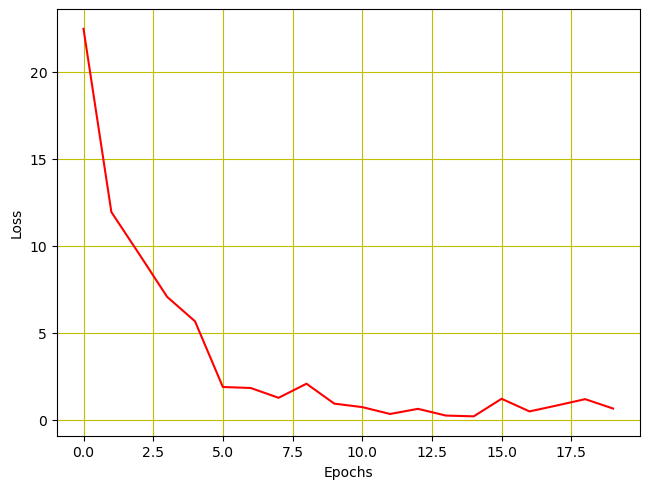

In [10]:
plt.plot(loss_list1, 'r')
plt.tight_layout()
plt.grid(True,color='y')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Neural Network #2

In [11]:
class RegressionModel2(torch.nn.Module):
    def __init__(self,input_size):
        super(RegressionModel2, self).__init__()
        self.layer1=torch.nn.Linear(input_size, 10)
        self.layer2=torch.nn.Linear(10,20)
        self.layer3=torch.nn.Linear(20,10)
        self.layer4=torch.nn.Linear(10,1)
        self.activation=torch.nn.ReLU()

    def forward(self,x):
        x=self.layer1(x)
        x=self.activation(x)
        x=self.layer2(x)
        x=self.activation(x)
        x=self.layer3(x)
        x=self.activation(x)
        x=self.layer4(x)
        return x

nnet2=RegressionModel2(9)

In [12]:
batch_size= 32

summary(nnet2, input_size=(batch_size,9),device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
RegressionModel2                         [32, 1]                   --
├─Linear: 1-1                            [32, 10]                  100
├─ReLU: 1-2                              [32, 10]                  --
├─Linear: 1-3                            [32, 20]                  220
├─ReLU: 1-4                              [32, 20]                  --
├─Linear: 1-5                            [32, 10]                  210
├─ReLU: 1-6                              [32, 10]                  --
├─Linear: 1-7                            [32, 1]                   11
Total params: 541
Trainable params: 541
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [13]:
criterion = torch.nn.MSELoss()
optimizer= torch.optim.SGD(nnet2.parameters(), lr=0.01)

In [14]:
# Define an empty list to store the loss values
loss_list2 = []

for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get inputs
        inputs, labels = data
        
        #zero parameter gradients
        optimizer.zero_grad()

        #forward, backward, optimize
        outputs = nnet2(inputs)
        loss=criterion(outputs,labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        #print
        running_loss += loss.item()
        if i % 12 == 11:
            print(f'[{epoch + 1}, {i+1:5d}] loss: {running_loss / 12:.3f}')
            running_loss=0.0
            
    loss_list2.append(running_loss / len(trainloader))
print('Finished Training')


[1,    12] loss: 454.221
[2,    12] loss: 125.184
[3,    12] loss: 43.113
[4,    12] loss: 24.932
[5,    12] loss: 30.737
[6,    12] loss: 14.728
[7,    12] loss: 12.927
[8,    12] loss: 14.305
[9,    12] loss: 19.893
[10,    12] loss: 14.060
[11,    12] loss: 17.055
[12,    12] loss: 10.005
[13,    12] loss: 15.467
[14,    12] loss: 9.313
[15,    12] loss: 8.683
[16,    12] loss: 10.225
[17,    12] loss: 9.303
[18,    12] loss: 11.383
[19,    12] loss: 10.719
[20,    12] loss: 8.651
Finished Training


Accuracy

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        # get inputs
        inputs, labels = data

        outputs = nnet2(inputs)
        for i in range(len(labels)):
            if abs(outputs[i].item() - labels[i]) <= 5:
                correct += 1
            total += 1
acc2=100*correct/total
print(f'Approx. accuracy of the network: {100*correct/total:.2f} %')


Approx. accuracy of the network: 85.20 %


Plot loss

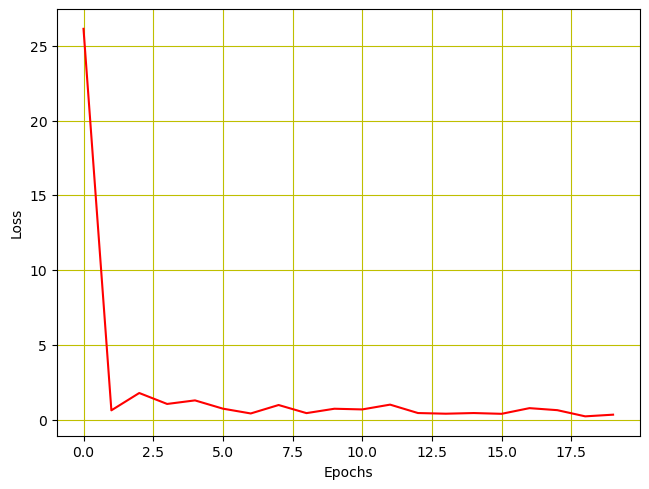

In [16]:
plt.plot(loss_list2, 'r')
plt.tight_layout()
plt.grid(True,color='y')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Neural Network #3

In [17]:
class RegressionModel3(torch.nn.Module):
    def __init__(self,input_size):
        super(RegressionModel3, self).__init__()
        self.layer1=torch.nn.Linear(input_size, 10)
        self.layer2=torch.nn.Linear(10,20)
        self.layer3=torch.nn.Linear(20,30)
        self.layer4=torch.nn.Linear(30,20)
        self.layer5=torch.nn.Linear(20,1)
        self.activation=torch.nn.ReLU()

    def forward(self,x):
        x=self.layer1(x)
        x=self.activation(x)
        x=self.layer2(x)
        x=self.activation(x)
        x=self.layer3(x)
        x=self.activation(x)
        x=self.layer4(x)
        x=self.activation(x)
        x=self.layer5(x)
        return x

nnet3=RegressionModel3(9)

In [18]:
batch_size= 32

summary(nnet3, input_size=(batch_size,9),device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
RegressionModel3                         [32, 1]                   --
├─Linear: 1-1                            [32, 10]                  100
├─ReLU: 1-2                              [32, 10]                  --
├─Linear: 1-3                            [32, 20]                  220
├─ReLU: 1-4                              [32, 20]                  --
├─Linear: 1-5                            [32, 30]                  630
├─ReLU: 1-6                              [32, 30]                  --
├─Linear: 1-7                            [32, 20]                  620
├─ReLU: 1-8                              [32, 20]                  --
├─Linear: 1-9                            [32, 1]                   21
Total params: 1,591
Trainable params: 1,591
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03

In [19]:
criterion = torch.nn.MSELoss()
optimizer= torch.optim.SGD(nnet3.parameters(), lr=0.01)

In [20]:
# Define an empty list to store the loss values
loss_list3 = []

for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get inputs
        inputs, labels = data
        
        #zero parameter gradients
        optimizer.zero_grad()

        #forward, backward, optimize
        outputs = nnet3(inputs)
        loss=criterion(outputs,labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        #print
        running_loss += loss.item()
        if i % 12 == 11:
            print(f'[{epoch + 1}, {i+1:5d}] loss: {running_loss / 12:.3f}')
            running_loss=0.0
            
    loss_list3.append(running_loss / len(trainloader))
print('Finished Training')


[1,    12] loss: 324.138
[2,    12] loss: 144.019
[3,    12] loss: 363.977
[4,    12] loss: 193.259
[5,    12] loss: 61.143
[6,    12] loss: 60.373
[7,    12] loss: 44.558
[8,    12] loss: 63.666
[9,    12] loss: 23.993
[10,    12] loss: 21.242
[11,    12] loss: 27.382
[12,    12] loss: 28.412
[13,    12] loss: 24.772
[14,    12] loss: 26.641
[15,    12] loss: 23.470
[16,    12] loss: 16.250
[17,    12] loss: 28.098
[18,    12] loss: 22.949
[19,    12] loss: 17.609
[20,    12] loss: 20.560
Finished Training


Accuracy

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        # get inputs
        inputs, labels = data

        outputs = nnet3(inputs)
        for i in range(len(labels)):
            if abs(outputs[i].item() - labels[i]) <= 5:
                correct += 1
            total += 1
acc3=100*correct/total
print(f'Approx. accuracy of the network: {100*correct/total:.2f} %')


Approx. accuracy of the network: 87.24 %


Plot loss

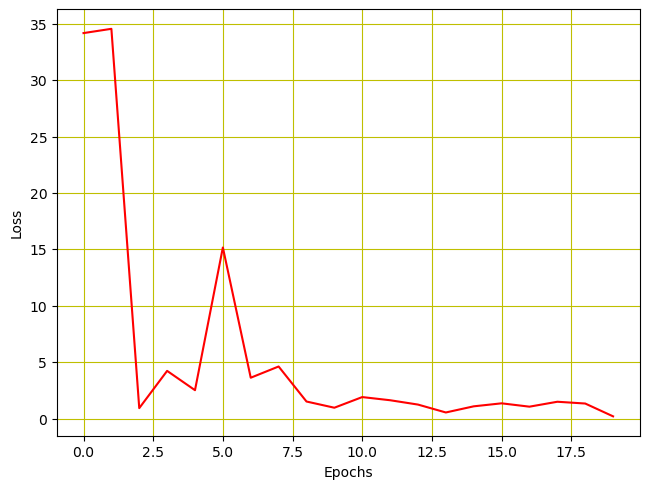

In [22]:
plt.plot(loss_list3, 'r')
plt.tight_layout()
plt.grid(True,color='y')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Comparison between models

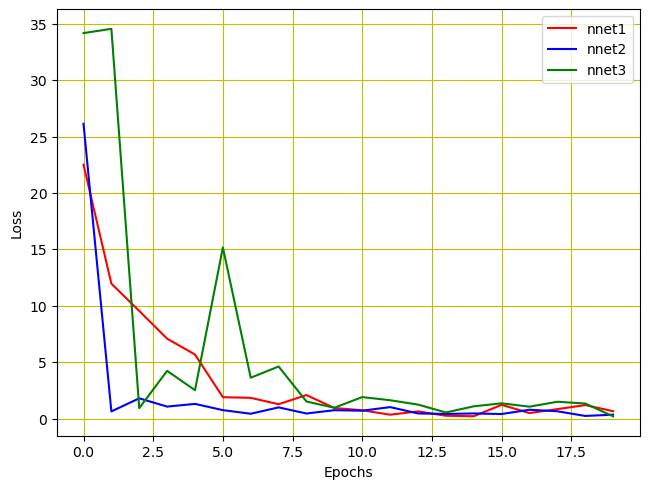

In [23]:
plt.plot(loss_list1, 'r', label='nnet1')
plt.plot(loss_list2, 'b', label='nnet2')
plt.plot(loss_list3, 'g', label='nnet3')
plt.tight_layout()
plt.grid(True,color='y')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
print("NNet1 Accuracy: ", acc1)
print("NNet2 Accuracy: ", acc2)
print("NNet3 Accuracy: ", acc3)

NNet1 Accuracy:  87.5
NNet2 Accuracy:  85.20408163265306
NNet3 Accuracy:  87.24489795918367


We are going to answer the following question:

i) Which of the three models had the least amount of error for validation? 

Taking into consideration the approximate accuracy of each network, and analyzing the graphs, the model nominated RegressionModel1 has the best results. Note that model RegressionModel2 has the quickest convergence, but it doesn't reach lower values of loss, and if it does, it alternates between them (although not as noticeable as RegressionModel3), where RegressionModel1 remains relatively constant. RegressionModel3 seems to converge, but alternates significantly in terms of the loss, which might indicate a potential problem of vanishing/exploding gradient.


ii) How long it took to train each model?

All models took 0.2s.
